# Imports

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import json
import csv

import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader, TensorDataset


import pandas as pd
import seaborn as sns
import time

# project root (one level above 'notebooks/') to the path - go to the parent of 'src/'
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

results_dir = os.path.join(project_root, "results")
gridsearch_path = os.path.join(results_dir, "gridsearch", "sa_adam_nn")
final_results_path = os.path.join(results_dir, "analytical", "sa_gd_nn")

os.makedirs(gridsearch_path, exist_ok=True)
os.makedirs(final_results_path, exist_ok=True)

from src.optimizers.sa_nn import sa_nn
from src.optimizers.gd_nn import gd_nn
from src.problems.nn import init_weights, flatten_weights, unflatten_weights

In [3]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 

In [4]:
# random seed set
np.random.seed(0)

In [5]:
wine_data = load_wine()
df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
df['target'] = wine_data.target
df = df[['target'] + [col for col in df.columns if col != 'target']]

In [6]:
# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# extract features and target
X = wine_quality.data.features
y = wine_quality.data.targets

# concatenate target and features into one dataframe, with target as first column
df = pd.concat([y, X], axis=1)
df.columns = ['target'] + list(X.columns)

In [7]:
# group target into 3 classes: 0 (low), 1 (medium), 2 (high)
df["target_grouped"] = df["target"].map(lambda x: 0 if x <= 5 else 1)

# move target_grouped to first column
cols = ["target_grouped"] + [col for col in df.columns if col not in ["target_grouped", "target"]]
df = df[cols]

In [8]:
df.head()

,target_grouped,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


# Basic EDA

In [9]:
df.describe()

,target_grouped,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.633061,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,0.482007,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   target_grouped        6497 non-null   int64  
 1   fixed_acidity         6497 non-null   float64
 2   volatile_acidity      6497 non-null   float64
 3   citric_acid           6497 non-null   float64
 4   residual_sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free_sulfur_dioxide   6497 non-null   float64
 7   total_sulfur_dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [11]:
df['target_grouped'].value_counts()


target_grouped
1    4113
0    2384
Name: count, dtype: int64

In [12]:
df.isnull().sum()

target_grouped          0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

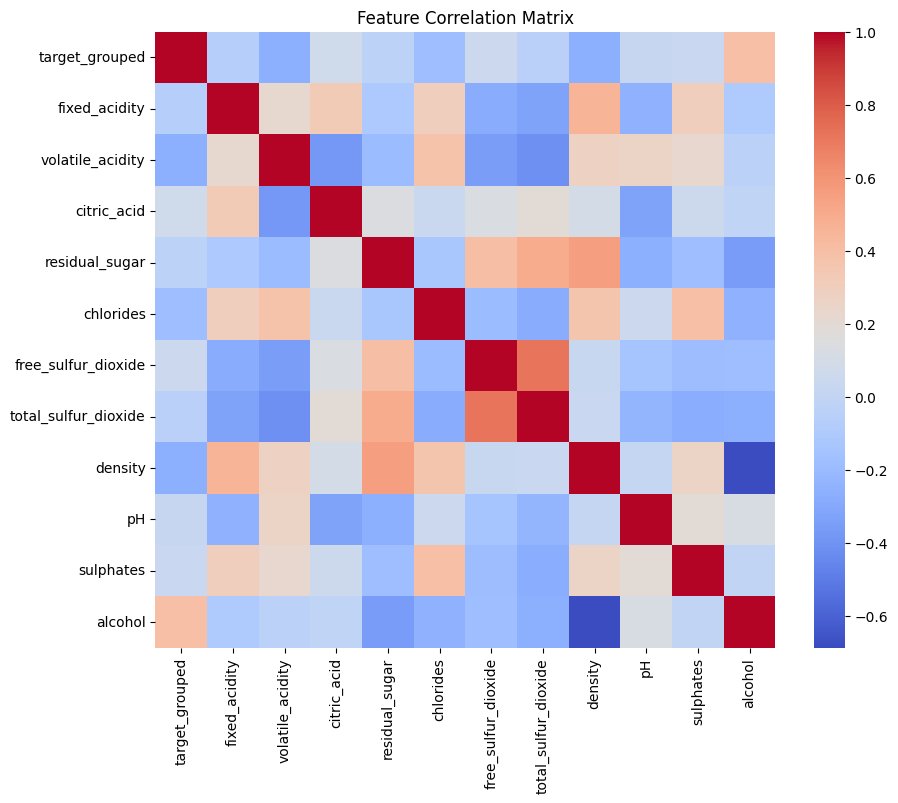

In [13]:
# feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

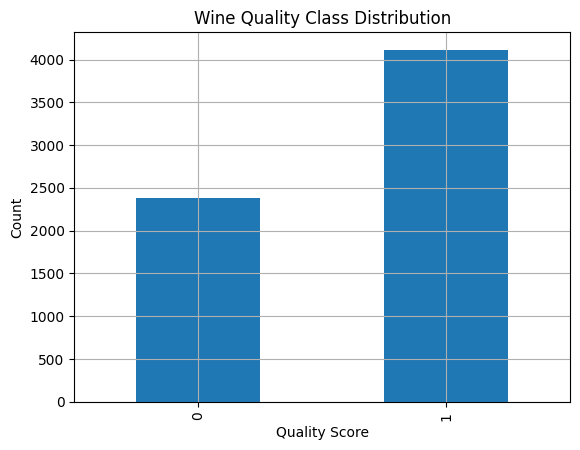

In [14]:
df['target_grouped'].value_counts().sort_index().plot(kind='bar')
plt.title("Wine Quality Class Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Preprocessing

In [15]:
X = df.drop(columns=["target_grouped"]).values
y = df["target_grouped"].values

# normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape:", X.shape)
print("Classes:", np.bincount(y))

Shape: (6497, 11)
Classes: [2384 4113]


In [16]:
# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# NN Architecture

In [27]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def flatten_model_weights(model):
    return torch.cat([p.view(-1) for p in model.parameters()]).detach().cpu().numpy()

def set_model_weights(model, flat_weights):
    with torch.no_grad():
        offset = 0
        for p in model.parameters():
            shape = p.shape
            size = p.numel()
            new_weights = flat_weights[offset:offset+size].reshape(shape)
            p.copy_(torch.tensor(new_weights, dtype=p.dtype))
            offset += size

In [18]:
# Define layer sizes
input_dim = X_temp.shape[1]
hidden_dim = 32
output_dim = len(np.unique(y_temp))
layer_sizes = [input_dim, hidden_dim, output_dim]

# Cross-validation setup
n_splits = 5
outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# GD

In [61]:
def run_gridsearch_adam_nn(X, y, input_dim, hidden_dim, output_dim, save_path):
    lrs = [0.001, 0.01, 0.1, 0.3, 0.5]
    batch_sizes = [16, 32, 64]
    # lrs = [0.001, 0.01]
    # batch_sizes = [16]
    param_grid = [(lr, bs) for lr in lrs for bs in batch_sizes]
    total = len(param_grid)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rows = []

    for idx, (lr, bs) in enumerate(param_grid, 1):
        print(f"\n[{idx}/{total}] Running: lr = {lr}, batch_size = {bs}")
        t0 = time.time()
        fold_accs, fold_prec, fold_rec, fold_f1 = [], [], [], []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                     torch.tensor(y_train, dtype=torch.long))
            val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                   torch.tensor(y_val, dtype=torch.long))

            train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
            val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False)

            model = SimpleNN(input_dim, hidden_dim, output_dim)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()

            # Train
            for epoch in range(50):
                model.train()
                for xb, yb in train_loader:
                    optimizer.zero_grad()
                    loss = criterion(model(xb), yb)
                    loss.backward()
                    optimizer.step()

            # Evaluate
            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for xb, yb in val_loader:
                    preds = model(xb).argmax(dim=1).numpy()
                    all_preds.extend(preds)
                    all_labels.extend(yb.numpy())

            report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
            fold_accs.append(report["accuracy"])
            fold_prec.append(report["1"]["precision"])
            fold_rec.append(report["1"]["recall"])
            fold_f1.append(report["1"]["f1-score"])

        # Save metrics
        row = {
            "lr": lr,
            "batch_size": bs,
            "val_accuracy": np.mean(fold_accs),
            "val_precision_class1": np.mean(fold_prec),
            "val_recall_class1": np.mean(fold_rec),
            "val_f1_class1": np.mean(fold_f1),
            "time_seconds": round(time.time() - t0, 2)
        }
        rows.append(row)
        print(f"    → Done in {row['time_seconds']}s | Val Acc: {row['val_accuracy']:.4f} | F1: {row['val_f1_class1']:.4f}")

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(save_path, "gridsearch_adam_nn.csv"), index=False)
    print(f"\n✅ Grid search finished. Results saved to {save_path}/gridsearch_adam_nn.csv")
    return df


In [63]:
df_results_adam = run_gridsearch_adam_nn(X_temp, y_temp, input_dim, hidden_dim, output_dim, gridsearch_path)


[1/15] Running: lr = 0.001, batch_size = 16
    → Done in 151.54s | Val Acc: 0.7697 | F1: 0.8230

[2/15] Running: lr = 0.001, batch_size = 32
    → Done in 125.66s | Val Acc: 0.7676 | F1: 0.8239

[3/15] Running: lr = 0.001, batch_size = 64
    → Done in 53.83s | Val Acc: 0.7652 | F1: 0.8188

[4/15] Running: lr = 0.01, batch_size = 16
    → Done in 164.84s | Val Acc: 0.7537 | F1: 0.8039

[5/15] Running: lr = 0.01, batch_size = 32
    → Done in 86.86s | Val Acc: 0.7622 | F1: 0.8160

[6/15] Running: lr = 0.01, batch_size = 64
    → Done in 49.3s | Val Acc: 0.7589 | F1: 0.8126

[7/15] Running: lr = 0.1, batch_size = 16
    → Done in 215.11s | Val Acc: 0.7360 | F1: 0.7976

[8/15] Running: lr = 0.1, batch_size = 32
    → Done in 86.11s | Val Acc: 0.7327 | F1: 0.7989

[9/15] Running: lr = 0.1, batch_size = 64
    → Done in 59.85s | Val Acc: 0.7450 | F1: 0.8095

[10/15] Running: lr = 0.3, batch_size = 16
    → Done in 164.21s | Val Acc: 0.5803 | F1: 0.6210

[11/15] Running: lr = 0.3, batch_si

In [65]:
# === Load grid search results and find best hyperparameters ===
grid_results_path = os.path.join(gridsearch_path, "gridsearch_adam_nn.csv")
df_grid = pd.read_csv(grid_results_path)

# select best row by validation accuracy
best_row = df_grid.loc[df_grid["val_accuracy"].idxmax()]
best_lr = best_row["lr"]
best_bs = int(best_row["batch_size"])
print(f"Best hyperparameters found: learning rate = {best_lr}, batch size = {best_bs}")

Best hyperparameters found: learning rate = 0.001, batch size = 16


In [66]:
# === Train final model on full train+val set ===
final_model = SimpleNN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

trainval_ds = TensorDataset(torch.tensor(X_temp, dtype=torch.float32),
                            torch.tensor(y_temp, dtype=torch.long))
trainval_loader = DataLoader(trainval_ds, batch_size=best_bs, shuffle=True)

for epoch in range(50):
    final_model.train()
    for xb, yb in trainval_loader:
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()


[ADAM] Test Accuracy = 0.7762

[ADAM] Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.6962    0.6918    0.6940       477
           1     0.8220    0.8250    0.8235       823

    accuracy                         0.7762      1300
   macro avg     0.7591    0.7584    0.7588      1300
weighted avg     0.7759    0.7762    0.7760      1300



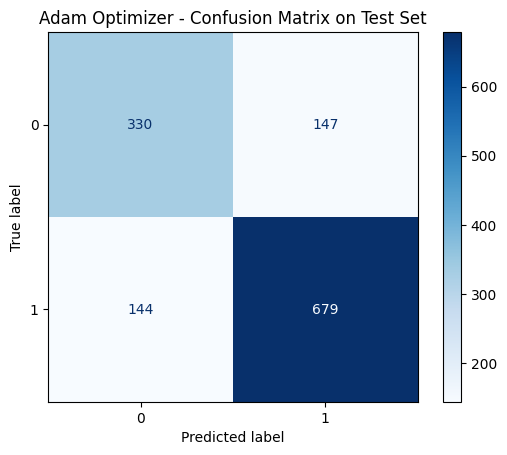

In [67]:
# === Evaluate on test set ===
final_model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

with torch.no_grad():
    preds = final_model(X_test_tensor).argmax(dim=1).numpy()

# test accuracy
acc = accuracy_score(y_test, preds)
print(f"\n[ADAM] Test Accuracy = {acc:.4f}")

# classification report
print("\n[ADAM] Classification Report on Test Set:")
print(classification_report(y_test, preds, digits=4))

# confusion matrix
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title("Adam Optimizer - Confusion Matrix on Test Set")
plt.grid(False)
plt.show()

In [68]:
# === Save test evaluation report to CSV ===
report_dict = classification_report(y_test, preds, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).T
report_df["test_accuracy"] = acc

save_file = os.path.join(final_results_path, "adam_nn_test_evaluation.csv")
report_df.to_csv(save_file)

print(f"\nTest evaluation report saved to: {save_file}")


Test evaluation report saved to: c:\Users\emmaa\OneDrive\Documents\0.BOCCONI\THESIS\gd-sa-optimization\results\analytical\sa_gd_nn\adam_nn_test_evaluation.csv


# SA

In [81]:
def run_gridsearch_sa_nn(X, y, input_dim, hidden_dim, output_dim, save_path, N=10):
    T0_values = [1.0, 5.0, 10.0]
    step_sizes = [0.1, 0.3, 0.5]
    alphas = [0.95, 0.98, 0.99]

    param_grid = list(ParameterGrid({
        "T0": T0_values,
        "step_size": step_sizes,
        "alpha": alphas
    }))

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for idx, params in enumerate(param_grid, 1):
        print(f"\n[{idx}/{len(param_grid)}] Testing: T0={params['T0']}, step_size={params['step_size']}, alpha={params['alpha']}")
        t0 = time.time()

        accs, precs, recs, f1s = [], [], [], []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            for _ in range(N):
                theta_star, _, _, _ = sa_nn(
                    X_train, y_train,
                    input_dim, hidden_dim, output_dim,
                    max_iter=200000,
                    T0=params["T0"],
                    alpha=params["alpha"],
                    step_size=params["step_size"]
                )

                y_pred = sa_nn.predict(theta_star, X_val, input_dim, hidden_dim, output_dim)
                report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

                accs.append(report["accuracy"])
                precs.append(report["1"]["precision"])
                recs.append(report["1"]["recall"])
                f1s.append(report["1"]["f1-score"])

        row = {
            "T0": params["T0"],
            "step_size": params["step_size"],
            "alpha": params["alpha"],
            "val_accuracy": np.mean(accs),
            "val_precision_class1": np.mean(precs),
            "val_recall_class1": np.mean(recs),
            "val_f1_class1": np.mean(f1s),
            "time_seconds": round(time.time() - t0, 2)
        }
        results.append(row)
        print(f"    → Done in {row['time_seconds']}s | Avg Val Acc: {row['val_accuracy']:.4f}")

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(save_path, "gridsearch_sa_nn.csv"), index=False)
    print(f"\n✅ Grid search completed. Results saved to {save_path}/gridsearch_sa_nn.csv")
    return df

In [ ]:
# === Run SA Grid Search ===
df_results_sa = run_gridsearch_sa_nn(X_temp, y_temp, input_dim, hidden_dim, output_dim, gridsearch_path)

In [82]:
# === Load best SA hyperparameters from grid search results ===
grid_results_path = os.path.join(gridsearch_path, "gridsearch_sa_nn.csv")
df_grid_sa = pd.read_csv(grid_results_path)

best_row_sa = df_grid_sa.loc[df_grid_sa["val_accuracy"].idxmax()]
best_T0 = best_row_sa["T0"]
best_step = best_row_sa["step_size"]
best_alpha = best_row_sa["alpha"]
print(f"Best SA hyperparameters found: T0 = {best_T0}, step_size = {best_step}, alpha = {best_alpha}")

Best SA hyperparameters found: T0 = 5.0, step_size = 0.01, alpha = 0.95


In [90]:
# === Per-run confusion matrices and classification reports (SA final eval) ===
sa_accuracies = []
sa_reports = []
conf_matrices = []

for i in range(20):
    print(f"[SA] Training model {i+1}/20")
    model = SimpleNN(input_dim, hidden_dim, output_dim)
    x_init = flatten_model_weights(model)
    layer_sizes = [input_dim, hidden_dim, output_dim]

    result = sa_nn(
        x_init=x_init,
        layer_sizes=layer_sizes,
        X_train=X_temp,
        y_train=y_temp,
        X_val=None,
        y_val=None,
        loss_type="cross_entropy",
        step_size=best_step,
        alpha=best_alpha,
        T0=best_T0,
        max_iter=200000,
        track_val_loss=False,
        track_val_accuracy=False,
        early_stopping=False,
        adaptive_step_size=False,
        verbose=False
    )

    best_x, _, _, _, _, _ = result
    set_model_weights(model, best_x)

    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_pred = model(X_test_tensor).argmax(dim=1).numpy()

        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        sa_accuracies.append(acc)
        sa_reports.append(report)
        conf_matrices.append(cm)

        # === Save individual report and confusion matrix ===
        report_df = pd.DataFrame(report).T
        report_df["test_accuracy"] = acc
        report_df.to_csv(os.path.join(final_results_path, f"sa_classification_report_run{i+1}.csv"))

        pd.DataFrame(cm).to_csv(os.path.join(final_results_path, f"sa_conf_matrix_run{i+1}.csv"), index=False)


[SA] Training model 1/20
[SA] Training model 2/20
[SA] Training model 3/20
[SA] Training model 4/20
[SA] Training model 5/20
[SA] Training model 6/20
[SA] Training model 7/20
[SA] Training model 8/20
[SA] Training model 9/20
[SA] Training model 10/20
[SA] Training model 11/20
[SA] Training model 12/20
[SA] Training model 13/20
[SA] Training model 14/20
[SA] Training model 15/20
[SA] Training model 16/20
[SA] Training model 17/20
[SA] Training model 18/20
[SA] Training model 19/20
[SA] Training model 20/20



✅ SA final averaged accuracy over 20 runs: 0.5493
📄 Reports saved to: c:\Users\emmaa\OneDrive\Documents\0.BOCCONI\THESIS\gd-sa-optimization\results\analytical\sa_gd_nn


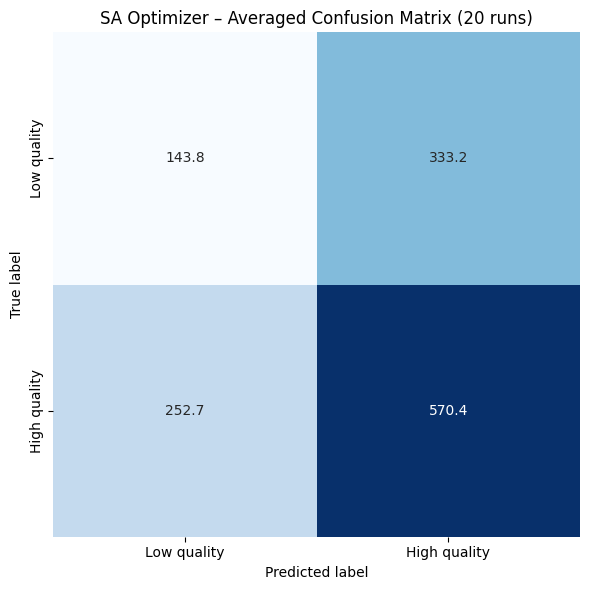

In [94]:
# === Average confusion matrix ===
avg_cm = np.mean(conf_matrices, axis=0)
plt.figure(figsize=(6, 6))
sns.heatmap(avg_cm, annot=True, fmt=".1f", cmap="Blues", cbar=False,
            xticklabels=["Low quality", "High quality"],
            yticklabels=["Low quality", "High quality"])
plt.title("SA Optimizer – Averaged Confusion Matrix (20 runs)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
pd.DataFrame(avg_cm).to_csv(os.path.join(final_results_path, "sa_nn_avg_confusion_matrix.csv"), index=False)

# === Average classification report ===
avg_report = {}
for key in sa_reports[0].keys():
    if isinstance(sa_reports[0][key], dict):
        avg_report[key] = {
            metric: np.mean([rep[key][metric] for rep in sa_reports])
            for metric in sa_reports[0][key]
        }
    else:
        avg_report[key] = np.mean([rep[key] for rep in sa_reports])

df_avg_report = pd.DataFrame(avg_report).T
df_avg_report["test_accuracy"] = np.mean(sa_accuracies)
df_avg_report.to_csv(os.path.join(final_results_path, "sa_nn_avg_classification_report.csv"))

print(f"\n✅ SA final averaged accuracy over 20 runs: {np.mean(sa_accuracies):.4f}")
print("📄 Reports saved to:", final_results_path)